# Cloud based Geospatial Data Processing

Prasun Kumar Gupta (IIRS/ISRO)

`prasun@iirs.gov.in`


This notebook as the following sections:
* Introduction to Cloud Native Geospatial Data Processsing using STAC, COG and Xarray
* Downloading COG data from AWS open data catalog
* Visualize raster data and metadata
* Processing 2 time period data and doing change detection


## Downloading COG data from AWS open data catalog

In this section we will see how to explore the Amazon Web Services (AWS) open data catalog, and download the Cloud Optimized GeoTIFFs (COG).

First step is to install the required packages.

In [ ]:
!pip install pystac_client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.7/207.7 kB 12.1 MB/s eta 0:00:00


In [ ]:
# We will now try to make a connection with the AWS client API
from pystac_client import Client

api_url = "https://earth-search.aws.element84.com/v1"
client = Client.open(api_url)

In [ ]:
print("***Printing the names of image collections in the AWS open data API***")
collections = client.get_all_collections()
for each_collection in collections:
  print(each_collection.id)

***Printing the names of image collections in the AWS open data API***
sentinel-2-pre-c1-l2a
cop-dem-glo-30
naip
cop-dem-glo-90
landsat-c2-l2
sentinel-2-l2a
sentinel-2-l1c
sentinel-2-c1-l2a
sentinel-1-grd


In [ ]:
# Setting a vairable collection to the S2 collection name
collection = "sentinel-2-l2a"

In [ ]:
from shapely.geometry import Point
point = Point(73.544005, 18.366689)  # Panshet coordinates

In [ ]:
import folium

# Create a map centered around the point
m = folium.Map(location=[point.y, point.x], zoom_start=11, width=400, height=300)

# Add a marker for the point
folium.Marker([point.y, point.x], popup="Panshet").add_to(m)

# Display the map
display(m)

In [ ]:
# An example of a simple catalog search using collection name and point of the location of interest.
search = client.search(
    collections=[collection],
    intersects=point,
    max_items=10
)

In [ ]:
# This show the number of scenes that matched our search criteria with the parameters assigned above
print(search.matched())

785


In [ ]:
# Now we retrieve the metadata of the search results by calling the method item_collection:
items = search.item_collection()

In [ ]:
print(len(items))

10


In [ ]:
# We can iterate over the returned items and print these to show their IDs
for item in items:
    print(item)

<Item id=S2B_43QCA_20251010_0_L2A>
<Item id=S2C_43QCA_20251005_0_L2A>
<Item id=S2B_43QCA_20250930_0_L2A>
<Item id=S2A_43QCA_20250927_0_L2A>
<Item id=S2C_43QCA_20250925_0_L2A>
<Item id=S2B_43QCA_20250920_0_L2A>
<Item id=S2C_43QCA_20250915_0_L2A>
<Item id=S2B_43QCA_20250910_0_L2A>
<Item id=S2A_43QCA_20250907_0_L2A>
<Item id=S2C_43QCA_20250905_0_L2A>


In [ ]:
'''
Let us look at the metadata of first item, which contains the
  information about the scene geometry, its acquisition time,
  and other metadata that can be accessed as a dictionary
  from the properties attribute.
'''
item = items[0]
print(item.datetime)
print(item.geometry)
print(item.properties)

2025-10-10 05:43:54.687000+00:00
{'type': 'Polygon', 'coordinates': [[[73.1163095879457, 18.982926901132814], [73.10102417802511, 18.913641991836123], [73.11114378622386, 17.990933946147493], [74.14797678232213, 17.998266544949992], [74.14305632414283, 18.99052878648329], [73.1163095879457, 18.982926901132814]]]}
{'created': '2025-10-10T09:14:37.443Z', 'platform': 'sentinel-2b', 'constellation': 'sentinel-2', 'instruments': ['msi'], 'eo:cloud_cover': 13.744092, 'proj:centroid': {'lat': 18.49086, 'lon': 73.62592}, 'mgrs:utm_zone': 43, 'mgrs:latitude_band': 'Q', 'mgrs:grid_square': 'CA', 'grid:code': 'MGRS-43QCA', 'view:azimuth': 104.79901935480346, 'view:incidence_angle': 6.798083675006504, 'view:sun_azimuth': 144.632526299654, 'view:sun_elevation': 59.6159004624801, 's2:tile_id': 'S2B_OPER_MSI_L2A_TL_2BPS_20251010T075840_A044890_T43QCA_N05.11', 's2:degraded_msi_data_percentage': 0.0212, 's2:nodata_pixel_percentage': 0.04778, 's2:saturated_defective_pixel_percentage': 0, 's2:cloud_shado

In [ ]:
# Let us add a filter on the cloud cover to select the only scenes
#   with less than 15% cloud coverage

bbox = point.buffer(0.1).bounds
search = client.search(
    collections=[collection],
    bbox=bbox,
    datetime="2020-03-20/2020-03-30",
    query=["eo:cloud_cover<15"]
)
print(search.matched())

6


In [ ]:
items = search.item_collection()
items.save_object("search.json")

In [ ]:
assets = items[0].assets  # first item's asset dictionary
print(assets.keys())

dict_keys(['aot', 'blue', 'coastal', 'granule_metadata', 'green', 'nir', 'nir08', 'nir09', 'red', 'rededge1', 'rededge2', 'rededge3', 'scl', 'swir16', 'swir22', 'thumbnail', 'tileinfo_metadata', 'visual', 'wvp', 'aot-jp2', 'blue-jp2', 'coastal-jp2', 'green-jp2', 'nir-jp2', 'nir08-jp2', 'nir09-jp2', 'red-jp2', 'rededge1-jp2', 'rededge2-jp2', 'rededge3-jp2', 'scl-jp2', 'swir16-jp2', 'swir22-jp2', 'visual-jp2', 'wvp-jp2'])


In [ ]:
# We can print a minimal description of the available assets
for key, asset in assets.items():
    print(f"{key}: {asset.title}")

aot: Aerosol optical thickness (AOT)
blue: Blue (band 2) - 10m
coastal: Coastal aerosol (band 1) - 60m
granule_metadata: None
green: Green (band 3) - 10m
nir: NIR 1 (band 8) - 10m
nir08: NIR 2 (band 8A) - 20m
nir09: NIR 3 (band 9) - 60m
red: Red (band 4) - 10m
rededge1: Red edge 1 (band 5) - 20m
rededge2: Red edge 2 (band 6) - 20m
rededge3: Red edge 3 (band 7) - 20m
scl: Scene classification map (SCL)
swir16: SWIR 1 (band 11) - 20m
swir22: SWIR 2 (band 12) - 20m
thumbnail: Thumbnail image
tileinfo_metadata: None
visual: True color image
wvp: Water vapour (WVP)
aot-jp2: Aerosol optical thickness (AOT)
blue-jp2: Blue (band 2) - 10m
coastal-jp2: Coastal aerosol (band 1) - 60m
green-jp2: Green (band 3) - 10m
nir-jp2: NIR 1 (band 8) - 10m
nir08-jp2: NIR 2 (band 8A) - 20m
nir09-jp2: NIR 3 (band 9) - 60m
red-jp2: Red (band 4) - 10m
rededge1-jp2: Red edge 1 (band 5) - 20m
rededge2-jp2: Red edge 2 (band 6) - 20m
rededge3-jp2: Red edge 3 (band 7) - 20m
scl-jp2: Scene classification map (SCL)
swi

In [ ]:
''' Among the other data files, assets include multiple raster data files
    (one per optical band, as acquired by the multi-spectral instrument),
    a thumbnail, a true-color image (“visual”), instrument metadata and
    scene-classification information (“SCL”). Let’s get the URL link
    to the thumbnail, which gives us a glimpse of the Sentinel-2 scene.
'''
print(assets["thumbnail"].href)

https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/43/Q/CA/2020/3/S2B_43QCA_20200330_1_L2A/thumbnail.jpg


In [ ]:
# In order to open the satellite images and investigate the scenes in more detail,
#   we will be using the rioxarray library. Let us first install it.
!pip install rioxarray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 95.9 MB/s eta 0:00:00


In [ ]:
''' Let us focus on the NIR band by accessing the item NIR from the
      assets dictionary and get the URL attribute using .href
      after the item selection.
'''
import rioxarray
nir_href = assets["nir"].href
nir = rioxarray.open_rasterio(nir_href)
print(nir)

<xarray.DataArray (band: 1, y: 10980, x: 10980)> Size: 241MB
[120560400 values with dtype=uint16]
Coordinates:
  * band         (band) int64 8B 1
  * y            (y) float64 88kB 2.1e+06 2.1e+06 2.1e+06 ... 1.99e+06 1.99e+06
  * x            (x) float64 88kB 3e+05 3e+05 3e+05 ... 4.098e+05 4.098e+05
    spatial_ref  int64 8B 0
Attributes:
    OVR_RESAMPLING_ALG:  AVERAGE
    AREA_OR_POINT:       Area
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0


In [ ]:
# We can save the whole image using the to_raster method
nir.rio.to_raster("nir.tif")

Saving the entire tile might take a while, given there are over 10000 x 10000 = a hundred million pixels in the 10-meter NIR band. But we can take a smaller subset before downloading it. Because the raster is a Cloud optimized geotiff (COG), we can download just what we need!

In order to do that, we are using rioxarray's `clip_box` with which you can set a bounding box defining the area you want.

In [ ]:
# Saving a portion of the image

nir_subset = nir.rio.clip_box(
    minx=73.415,
    miny=18.315,
    maxx=73.635,
    maxy=18.420,
    crs="EPSG:4326",
)

nir_subset.rio.to_raster("nir_subset.tif")

In [ ]:
# Look at the size difference of the 2 files
!ls -l --block-size=M

total 187M
-rw-r--r-- 1 root root   6M Oct 12 16:09 nir_subset.tif
-rw-r--r-- 1 root root 182M Oct 12 16:09 nir.tif
drwxr-xr-x 1 root root   1M Oct  9 13:36 sample_data
-rw-r--r-- 1 root root   1M Oct 12 16:08 search.json


## Visualize raster data and metadata

Here we will see different stretching techniques to visualize single and multi-band raster data

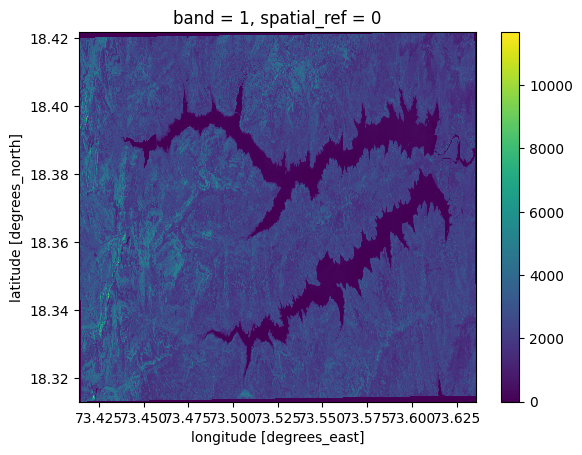

In [ ]:
# Display the nir_subset image with coordinates in EPSG:4326
nir_subset_4326 = nir_subset.rio.reproject("EPSG:4326")
nir_subset_4326.plot()

In [ ]:
# View the metadata of the raster
print(nir_subset_4326.rio.crs)
print(nir_subset_4326.rio.nodata)
print(nir_subset_4326.rio.bounds())
print(nir_subset_4326.rio.width)
print(nir_subset_4326.rio.height)

EPSG:4326
0
(73.41403180205022, 18.313219852280874, 73.63587510600816, 18.421749536289045)
2365
1157


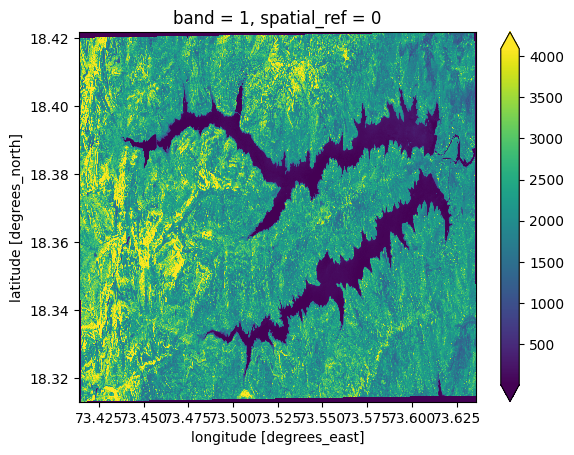

In [ ]:
# The option robust=True will forces displaying values between
#   the 2nd and 98th percentile
nir_subset_4326.plot(robust=True)

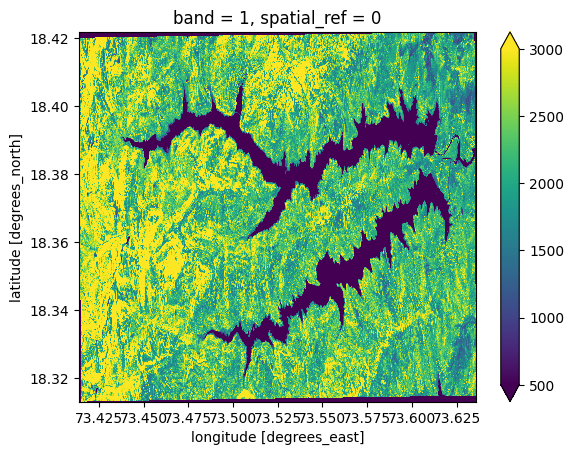

In [ ]:
nir_subset_4326.plot(vmin=500, vmax=3000)

**Calculate Raster Statistics**

It is useful to know the minimum or maximum values of a raster dataset. We can compute these and other descriptive statistics with min, max, mean, and std.

In [ ]:
print(nir_subset_4326.min())
print(nir_subset_4326.max())
print(nir_subset_4326.mean())
print(nir_subset_4326.std())

<xarray.DataArray ()> Size: 2B
array(0, dtype=uint16)
Coordinates:
    spatial_ref  int64 8B 0
<xarray.DataArray ()> Size: 2B
array(11680, dtype=uint16)
Coordinates:
    spatial_ref  int64 8B 0
<xarray.DataArray ()> Size: 8B
array(2143.59940431)
Coordinates:
    spatial_ref  int64 8B 0
<xarray.DataArray ()> Size: 8B
array(965.8944251)
Coordinates:
    spatial_ref  int64 8B 0


In [ ]:
# If we want to see specific quantiles, we can use xarray’s .quantile() method.
print(nir_subset_4326.quantile([0.25, 0.75]))

<xarray.DataArray (quantile: 2)> Size: 16B
array([1846., 2640.])
Coordinates:
  * quantile  (quantile) float64 16B 0.25 0.75


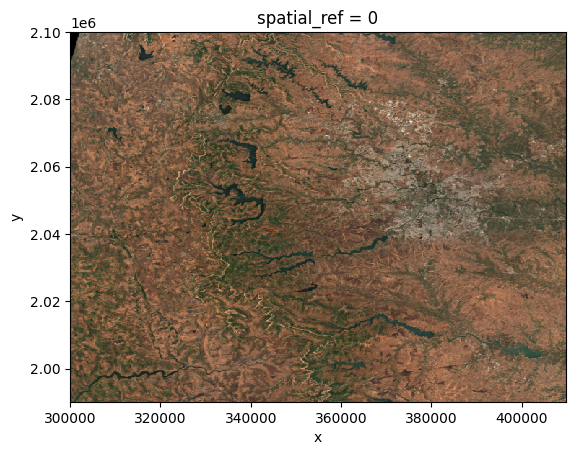

In [ ]:
raster_true_color = rioxarray.open_rasterio(items[0].assets['visual'].href, overview_level=3)
raster_true_color.plot.imshow()

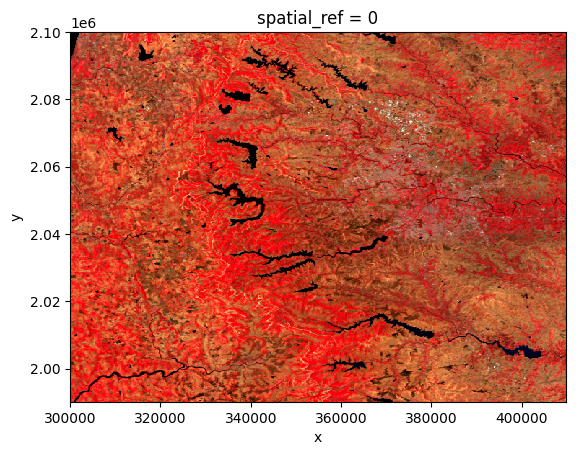

In [ ]:
# To plot a standard False Color Composite (FCC), we need the NIR, Red, and Green bands.
# We can open these directly from the assets.
import xarray as xr

red_href = items[0].assets['red'].href
green_href = items[0].assets['green'].href
nir_href = items[0].assets['nir'].href

# Open the bands using rioxarray
red = rioxarray.open_rasterio(red_href, overview_level=3)
green = rioxarray.open_rasterio(green_href, overview_level=3)
nir = rioxarray.open_rasterio(nir_href, overview_level=3)

# Stack the bands in the order NIR, Red, Green for a standard FCC
# This might require reprojecting bands to a common CRS if they differ,
# but for Sentinel-2 L2A COGs from the same item, they should align.
# We will stack them along a new dimension.
fcc = xr.concat([nir, red, green], dim="band")

# Plot the FCC
# The imshow function expects dimensions in the order (y, x, band)
# We need to swap the band dimension to the last position
fcc.plot.imshow(robust=True)

In [ ]:
# Panshet dam area
minx=73.415
miny=18.315
maxx=73.635
maxy=18.420

## Processing 2 time period data and doing change detection

Analyze the change in surface water area of the Panshet dam between the pre-monsoon and post-monsoon seasons of 2024 using Sentinel-2 L2A data. Calculate the NDWI for both periods, threshold it to identify water bodies, and quantify the change in water area in square kilometers. Visualize the NDWI images and the change.

In [ ]:
# Search for data for the pre-monsoon period in 2024
search_pre_monsoon = client.search(
    collections=[collection],
    bbox=[minx, miny, maxx, maxy],
    datetime="2024-03-01/2024-05-31",
    query=["eo:cloud_cover<2"]
)

# Print the number of matched items for the pre-monsoon search
print(f"Matched items for the pre-monsoon period: {search_pre_monsoon.matched()}")

# Search for data for the post-monsoon period in 2024
search_post_monsoon = client.search(
    collections=[collection],
    bbox=[minx, miny, maxx, maxy],
    datetime="2024-10-01/2024-12-31",
    query=["eo:cloud_cover<2"]
)

# Print the number of matched items for the post-monsoon search
print(f"Matched items for the post-monsoon period: {search_post_monsoon.matched()}")

Matched items for the pre-monsoon period: 12
Matched items for the post-monsoon period: 6


The NDWI (Normalized Difference Water Index) formula for Sentinel-2 is `(B3 - B8) / (B3 + B8)`, where `B3` is the Green band and `B8` is the Near-Infrared (NIR) band. This formula highlights water bodies because water absorbs NIR light while reflecting green light, resulting in positive NDWI values that indicate the presence of water.  

In [ ]:
# Access the item collections
items_pre_monsoon = search_pre_monsoon.item_collection()
items_post_monsoon = search_post_monsoon.item_collection()

# Select the first item from each collection
item_pre_monsoon = items_pre_monsoon[0]
item_post_monsoon = items_post_monsoon[0]

# Access 'green' and 'nir' assets for the selected items
green_pre_monsoon_href = item_pre_monsoon.assets['green'].href
nir_pre_monsoon_href = item_pre_monsoon.assets['nir'].href
green_post_monsoon_href = item_post_monsoon.assets['green'].href
nir_post_monsoon_href = item_post_monsoon.assets['nir'].href

# Open the bands using rioxarray without specifying overview_level
green_pre_monsoon = rioxarray.open_rasterio(green_pre_monsoon_href)
nir_pre_monsoon = rioxarray.open_rasterio(nir_pre_monsoon_href)
green_post_monsoon = rioxarray.open_rasterio(green_post_monsoon_href)
nir_post_monsoon = rioxarray.open_rasterio(nir_post_monsoon_href)

# Clip the bands to the Panshet dam area
green_pre_monsoon_clipped = green_pre_monsoon.rio.clip_box(minx=minx, miny=miny, maxx=maxx, maxy=maxy, crs="EPSG:4326")
nir_pre_monsoon_clipped = nir_pre_monsoon.rio.clip_box(minx=minx, miny=miny, maxx=maxx, maxy=maxy, crs="EPSG:4326")
green_post_monsoon_clipped = green_post_monsoon.rio.clip_box(minx=minx, miny=miny, maxx=maxx, maxy=maxy, crs="EPSG:4326")
nir_post_monsoon_clipped = nir_post_monsoon.rio.clip_box(minx=minx, miny=miny, maxx=maxx, maxy=maxy, crs="EPSG:4326")

# Display shapes to verify clipping
print("Shape of green_pre_monsoon_clipped:", green_pre_monsoon_clipped.shape)
print("Shape of nir_pre_monsoon_clipped:", nir_pre_monsoon_clipped.shape)
print("Shape of green_post_monsoon_clipped:", green_post_monsoon_clipped.shape)
print("Shape of nir_post_monsoon_clipped:", nir_post_monsoon_clipped.shape)

Shape of green_pre_monsoon_clipped: (1, 1182, 2335)
Shape of nir_pre_monsoon_clipped: (1, 1182, 2335)
Shape of green_post_monsoon_clipped: (1, 1182, 2335)
Shape of nir_post_monsoon_clipped: (1, 1182, 2335)


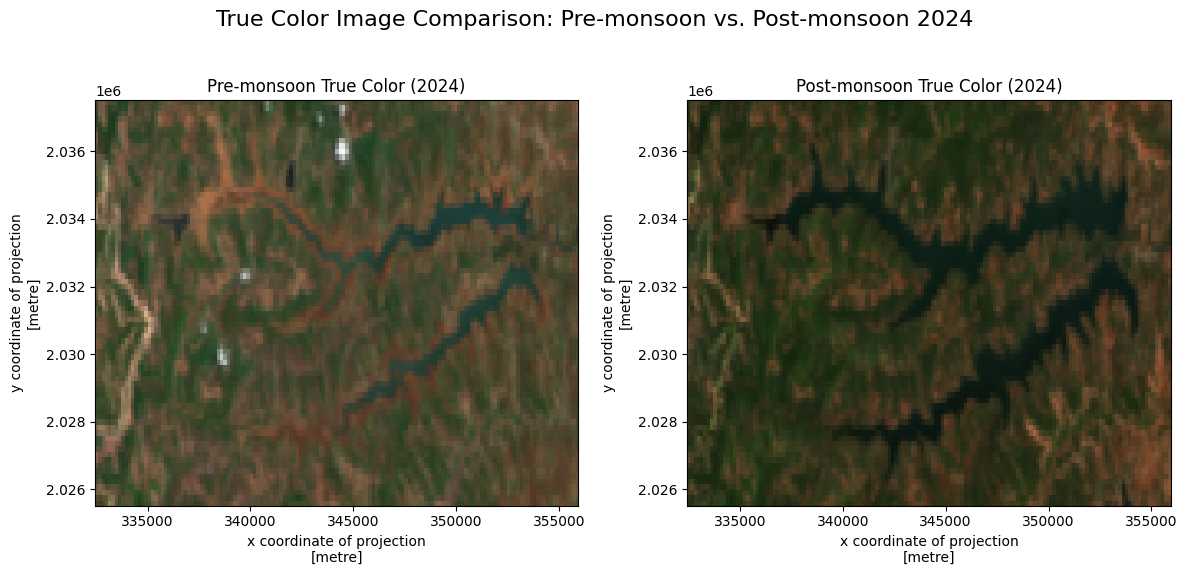

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the pre-monsoon true color image in the first subplot
raster_true_color_pre_monsoon = rioxarray.open_rasterio(item_pre_monsoon.assets['visual'].href, overview_level=3)
raster_true_color_pre_monsoon = raster_true_color_pre_monsoon.rio.clip_box(minx=minx, miny=miny, maxx=maxx, maxy=maxy, crs="EPSG:4326")
raster_true_color_pre_monsoon.plot.imshow(ax=axes[0])
axes[0].set_title("Pre-monsoon True Color (2024)")

# Plot the post-monsoon true color image in the second subplot
raster_true_color_post_monsoon = rioxarray.open_rasterio(item_post_monsoon.assets['visual'].href, overview_level=3)
raster_true_color_post_monsoon = raster_true_color_post_monsoon.rio.clip_box(minx=minx, miny=miny, maxx=maxx, maxy=maxy, crs="EPSG:4326")
raster_true_color_post_monsoon.plot.imshow(ax=axes[1])
axes[1].set_title("Post-monsoon True Color (2024)")

# Add a main title to the figure
fig.suptitle("True Color Image Comparison: Pre-monsoon vs. Post-monsoon 2024", fontsize=16)

# Adjust layout to prevent titles from overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust rect to make space for suptitle

# Display the plot
plt.show()

In [ ]:
# Calculate NDWI - pre-monsoon
ndwi_pre_monsoon = (green_pre_monsoon_clipped - nir_pre_monsoon_clipped) / (green_pre_monsoon_clipped + nir_pre_monsoon_clipped)
ndwi_pre_monsoon = ndwi_pre_monsoon.clip(min=-1, max=1)  # Clip values to the range [-1, 1]
ndwi_pre_monsoon.attrs["long_name"] = "NDWI"

# Calculate NDWI - pre-monsoon
ndwi_post_monsoon = (green_post_monsoon_clipped - nir_post_monsoon_clipped) / (green_post_monsoon_clipped + nir_post_monsoon_clipped)
ndwi_post_monsoon = ndwi_post_monsoon.clip(min=-1, max=1)  # Clip values to the range [-1, 1]
ndwi_post_monsoon.attrs["long_name"] = "NDWI"

# Print shapes to confirm calculations
print("Shape of ndwi_pre_monsoon:", ndwi_pre_monsoon.shape)
print("Shape of ndwi_post_monsoon:", ndwi_post_monsoon.shape)

Shape of ndwi_pre_monsoon: (1, 1182, 2335)
Shape of ndwi_post_monsoon: (1, 1182, 2335)


In [ ]:
# Define a threshold value for NDWI (adjust if necessary)
# A common threshold for NDWI is 1
ndwi_threshold = 1

# Apply the threshold to create binary water masks
water_mask_pre_monsoon = ndwi_pre_monsoon < ndwi_threshold
water_mask_post_monsoon = ndwi_post_monsoon < ndwi_threshold

# Get the spatial resolution of the clipped NDWI images
# Assuming the clipped images retain the original resolution in meters
# Sentinel-2 L2A green and nir bands have a resolution of 10 meters
pixel_resolution_meters = 10

# Calculate the area of a single pixel in square meters
pixel_area_sq_meters = pixel_resolution_meters * pixel_resolution_meters

# Count the number of water pixels in each mask
num_water_pixels_pre_monsoon = water_mask_pre_monsoon.sum().values
num_water_pixels_post_monsoon = water_mask_post_monsoon.sum().values

# Calculate the water area in square meters
water_area_sq_meters_pre_monsoon = num_water_pixels_pre_monsoon * pixel_area_sq_meters
water_area_sq_meters_post_monsoon = num_water_pixels_post_monsoon * pixel_area_sq_meters

# Convert the water area from square meters to square kilometers (1 sq km = 1,000,000 sq meters)
water_area_sq_km_pre_monsoon = water_area_sq_meters_pre_monsoon / 1_000_000
water_area_sq_km_post_monsoon = water_area_sq_meters_post_monsoon / 1_000_000

# Print the calculated water areas
print(f"Pre-monsoon water area: {water_area_sq_km_pre_monsoon:.2f} sq km")
print(f"Post-monsoon water area: {water_area_sq_km_post_monsoon:.2f} sq km")

Pre-monsoon water area: 15.22 sq km
Post-monsoon water area: 32.97 sq km


In [ ]:
# Calculate the difference in surface water area
water_area_change_sq_km = water_area_sq_km_post_monsoon - water_area_sq_km_pre_monsoon

# Print the calculated change in water area
print(f"Change in water area: {water_area_change_sq_km:.2f} sq km")

Change in water area: 17.75 sq km


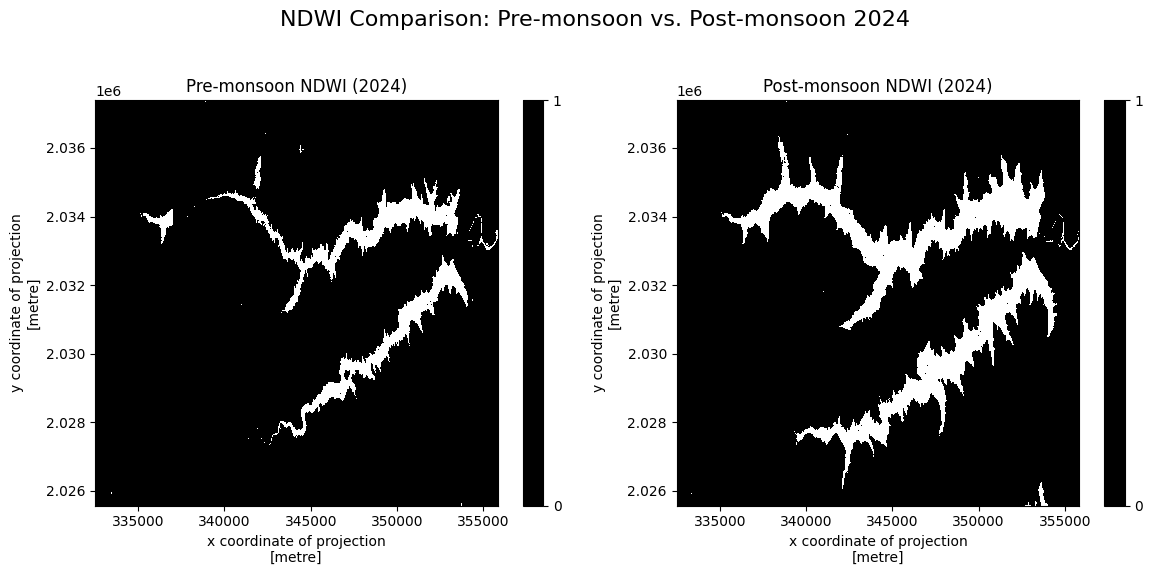

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Define the discrete levels and colormap
levels = [0, 1]
cmap = plt.matplotlib.colors.ListedColormap(['black', 'white'])

# Plot the pre-monsoon NDWI in the first subplot by selecting the single band
water_mask_pre_monsoon.plot(levels=levels, cmap=cmap, ax=axes[0])
axes[0].set_title("Pre-monsoon NDWI (2024)")

# Plot the post-monsoon NDWI in the second subplot by selecting the single band
water_mask_post_monsoon.plot(levels=levels, cmap=cmap, ax=axes[1])
axes[1].set_title("Post-monsoon NDWI (2024)")

# Add a main title to the figure
fig.suptitle("NDWI Comparison: Pre-monsoon vs. Post-monsoon 2024", fontsize=16)

# Adjust layout to prevent titles from overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust rect to make space for suptitle

# Display the plot
plt.show()